In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
df = pd.read_csv('../data/final_preprocessed_data_points.csv')
print(df.shape)
df.head(2)

(217, 23)


,_id,image_url,brands,pnns_groups_2,energy-kj_100g,sugars_100g,salt_100g,saturated-fat_100g,proteins_100g,fiber_100g,...,nutrition_grade_fr,negative_points,positive_points,energy_points,sugars_points,sodium_points,saturated_fat_points,fruit_points,fiber_points,proteins_points
0,3.251490e+12,https://images.openfoodfacts.org/images/produc...,Gerblé,Biscuits and cakes,1817,21.0,0.00,1.3,9.4,6.4,...,b,10,10,5,4,0,1,0,5,5
1,3.175680e+12,https://images.openfoodfacts.org/images/produc...,Gerblé,Biscuits and cakes,1961,17.0,0.38,2.0,10.0,4.6,...,b,10,9,5,3,0,1,0,4,5


In [126]:
en = "energy-kj_100g"
su = "sugars_100g"
fa = "saturated-fat_100g"
sa = "sodium_100g"
pr = "proteins_100g"
fi = "fiber_100g"
fr = "fruits-vegetables-nuts-estimate-from-ingredients_100g"

profiles = df.loc[:,[en, su, fa, sa, pr, fi, fr]]
print(profiles.shape)
profiles.head(2)

(217, 7)


,energy-kj_100g,sugars_100g,saturated-fat_100g,sodium_100g,proteins_100g,fiber_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
0,1817,21.0,1.3,0.000,9.4,6.4,21.95
1,1961,17.0,2.0,0.152,10.0,4.6,13.80


In [130]:
# drop data with saturated fat_100g > 10
profiles = profiles[profiles[fa] <= 5.1]
profiles = profiles[profiles[su] <= 35]
profiles = profiles[profiles[pr] <= 30]
profiles = profiles[profiles[fr] <= 60]
profiles = profiles[profiles[sa] <= 0.81]

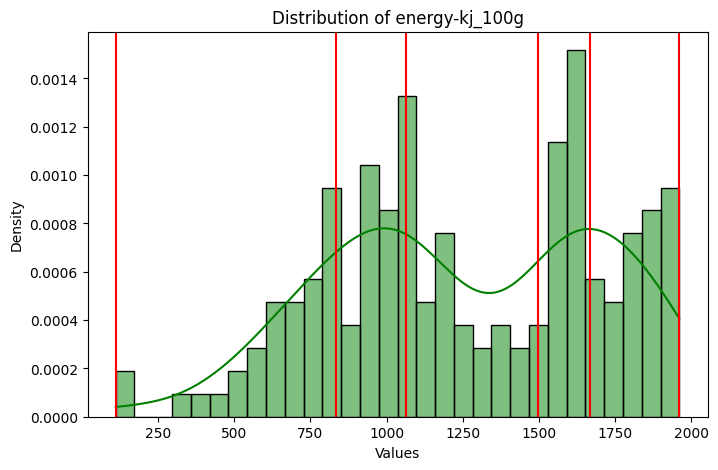

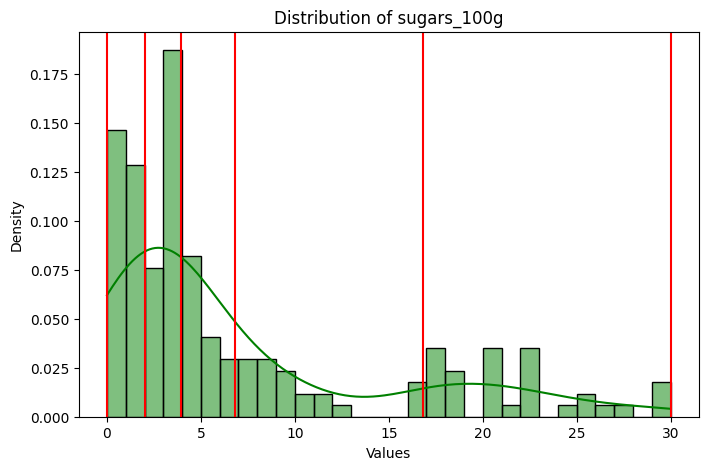

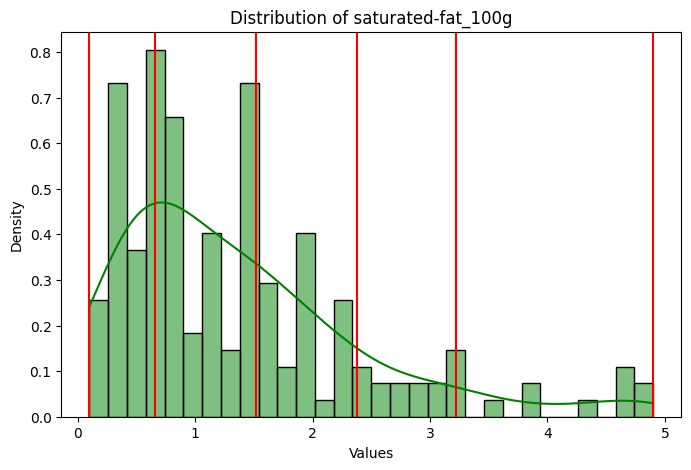

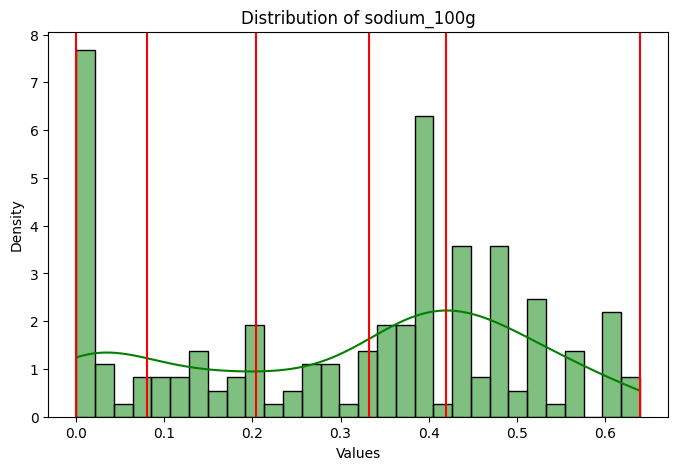

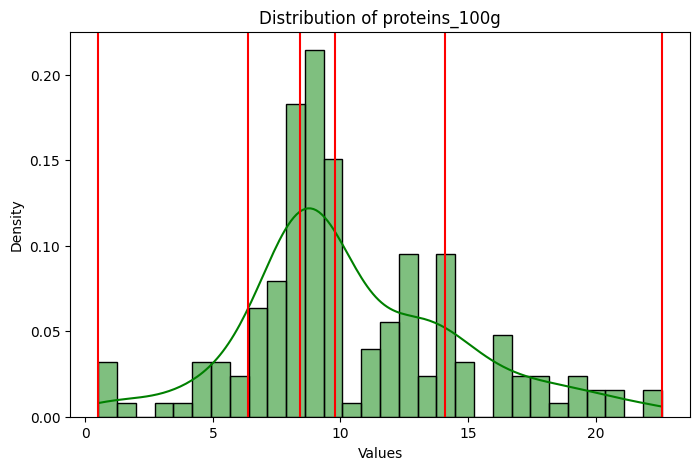

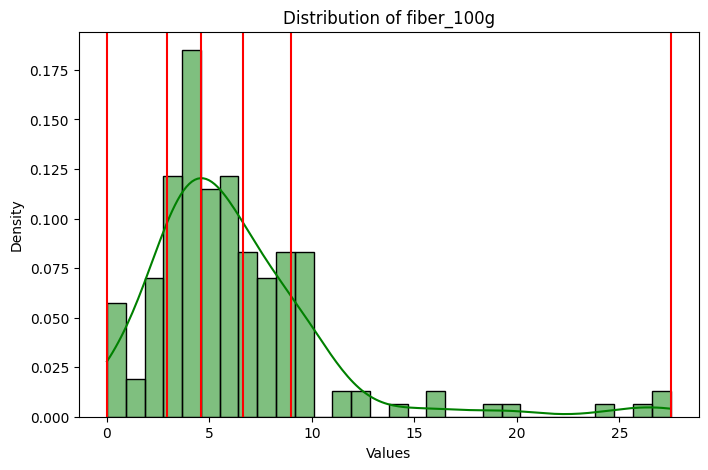

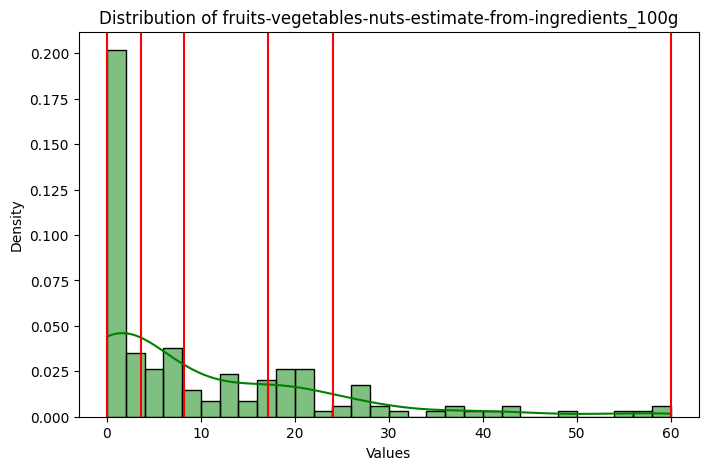

In [131]:
# Getting quantiles using numpy.percentile() for distinct columns values
quantiles = {}
for col in profiles.columns:
    quantiles[col] = np.percentile(profiles[col].unique(), [0, 20, 40, 60, 80, 100])

# Plotting distribution curves for each column
for col in profiles.columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(profiles[col], kde=True, bins=30, color='green', stat='density')
    plt.title(f'Distribution of {col}')
    plt.xlabel('Values')
    plt.ylabel('Density')
    for q in quantiles[col]:
        plt.axvline(x=q, color='red')
    plt.show()

In [132]:
# remove outliers from each column
for col in profiles.columns:
    profiles = profiles[profiles[col] <= quantiles[col][-2]]
    profiles = profiles[profiles[col] >= quantiles[col][1]]
print(profiles.shape)

(3, 7)


In [133]:
profile_dict = {}

# Creating a dictionary of criteria for each column
for col in profiles.columns:
    each_criteria = []
    for i in range(5):
        each_criteria.append((quantiles[col][i], quantiles[col][i+1]))
    profile_dict[col] = each_criteria

print(profile_dict)

{'energy-kj_100g': [(111.0, 834.6), (834.6, 1064.8), (1064.8, 1498.6), (1498.6, 1667.2), (1667.2, 1961.0)], 'sugars_100g': [(0.0, 2.04), (2.04, 3.94), (3.94, 6.800000000000001), (6.800000000000001, 16.799999999999997), (16.799999999999997, 30.0)], 'saturated-fat_100g': [(0.1, 0.6599999999999999), (0.6599999999999999, 1.52), (1.52, 2.38), (2.38, 3.22), (3.22, 4.9)], 'sodium_100g': [(0.0, 0.08), (0.08, 0.204), (0.204, 0.332), (0.332, 0.42), (0.42, 0.64)], 'proteins_100g': [(0.5, 6.36), (6.36, 8.42), (8.42, 9.78), (9.78, 14.08), (14.08, 22.6)], 'fiber_100g': [(0.0, 2.94), (2.94, 4.58), (4.58, 6.619999999999999), (6.619999999999999, 8.96), (8.96, 27.5)], 'fruits-vegetables-nuts-estimate-from-ingredients_100g': [(0.0, 3.6499999998000003), (3.6499999998000003, 8.169230769200002), (8.169230769200002, 17.1), (17.1, 24.036573660000002), (24.036573660000002, 60.0)]}


In [144]:
weights = [
    # {en: 1, su: 1, fa: 1, sa: 1, pr: 2, fi: 2, fr: 2},
    {en: 1, su: 1, fa: 1, sa: 1, pr: 1, fi: 1, fr: 1},

    # to add one more set of own weights{en: 1, su: 1, fa: 1, sa: 1, pr: 5, fi: 5, fr: 5}
]

In [145]:
def OptimisticMajoritySorting(data, profile_dict, weights):
    # build MR-Sort based on the profile_dict and weights, return the data with the categories assiged to it
    # loop over the data columns, check the value of each row use the weights it if it exceed the threshold y = 0.6, assign the category to the row
    # if the row does not exceed the threshold, assign it to the next category
    # reverse the  profile_dict
    for col in data.columns:
        for i in range(len(profile_dict[col])):
            # print(profile_dict[col][i])
            # print(profile_dict[col][i][0])
            # print(profile_dict[col][i][1])
            # print(data[col])
            # print((data[col] >= profile_dict[col][i][0]))
            # print((data[col] <= profile_dict[col][i][1]))
            # if the value of the row is between the range of the category, assign the category to the row by taking the threshold into account
            data.loc[(data[col] >= profile_dict[col][i][0]) & (data[col] <= profile_dict[col][i][1]), col] = i
            # return data
    data.to_csv('../data/preprocessed_elctri_model_col.csv', index=False) 
    # calculate the score for each row
    return data

In [146]:
reversed_dict = {}

for key, value in profile_dict.items():
    reversed_tuples = [(tup[1], tup[0]) for tup in value[::-1]]  # Reversing the tuples elements
    reversed_dict[key] = reversed_tuples

print(reversed_dict)

{'energy-kj_100g': [(1961.0, 1667.2), (1667.2, 1498.6), (1498.6, 1064.8), (1064.8, 834.6), (834.6, 111.0)], 'sugars_100g': [(30.0, 16.799999999999997), (16.799999999999997, 6.800000000000001), (6.800000000000001, 3.94), (3.94, 2.04), (2.04, 0.0)], 'saturated-fat_100g': [(4.9, 3.22), (3.22, 2.38), (2.38, 1.52), (1.52, 0.6599999999999999), (0.6599999999999999, 0.1)], 'sodium_100g': [(0.64, 0.42), (0.42, 0.332), (0.332, 0.204), (0.204, 0.08), (0.08, 0.0)], 'proteins_100g': [(22.6, 14.08), (14.08, 9.78), (9.78, 8.42), (8.42, 6.36), (6.36, 0.5)], 'fiber_100g': [(27.5, 8.96), (8.96, 6.619999999999999), (6.619999999999999, 4.58), (4.58, 2.94), (2.94, 0.0)], 'fruits-vegetables-nuts-estimate-from-ingredients_100g': [(60.0, 24.036573660000002), (24.036573660000002, 17.1), (17.1, 8.169230769200002), (8.169230769200002, 3.6499999998000003), (3.6499999998000003, 0.0)]}


# SKIP THIS next code, but don't delete it!!

In [147]:
# def PessimisticMajoritySorting(data_0, profile_dict, weights, thresholdPercentage):
#     """
#     This function performs Pessimistic Majority Sorting based on the profile_dict and weights.
#     It assigns categories to the data based on the majority sorting algorithm.

#     Parameters:
#     - data: pandas DataFrame, the input data
#     - profile_dict: dictionary, the profile dictionary containing the thresholds for each column
#     - weights: list of dictionaries, the weights for each category

#     Returns:
#     - data: pandas DataFrame, the data with assigned categories
#     """
#     # Make a copy of the data
#     data = pd.DataFrame.copy(data_0)
#     # define the columns 
#     columns = [en, su, fa, sa, pr, fi, fr]
#     error_rate = 0.001  # The error rate for the algorithm
#     # Iterate over each row and update cells based on conditions
#     for index, row in data.iterrows():
#         for col in columns:
#             for i in range(len(profile_dict[col])):
#                 lower_bound = profile_dict[col][i][1]
#                 upper_bound = profile_dict[col][i][0]
#                 if (lower_bound + error_rate) < row[col] <= (upper_bound + error_rate):
#                     data.at[index, col] = i +1 # shift the category by 1
#                     break  # Stop checking other ranges once a match is found
#     # for each column in the data, multiply the value of the row by the weight of the category
#     for col in columns:
#         for i in range(len(profile_dict[col])):
#             data.loc[data[col] == i, col] = weights[0][col] * i
#     # calculate the score for each row
#     data['score'] = data[columns].sum(axis=1)

#     # calculate the threshold for the score based on the threshold percentage
#     theshold = thresholdPercentage /100 * (len(next(iter(profile_dict.items()))[1]) * len(columns)) # the threshold for the score 50%

#     print(theshold)
#     # # assign the category between A, B, C, D, E based on the score and the threshold
#     for index, row in data.iterrows():
#         if row['score'] >= theshold:
#             data.at[index, 'category'] = 'A'
#         elif row['score'] >= theshold * 0.8:
#             data.at[index, 'category'] = 'B'
#         elif row['score'] >= theshold * 0.6:
#             data.at[index, 'category'] = 'C'
#         elif row['score'] >= theshold * 0.4:
#             data.at[index, 'category'] = 'D'
#         else:
#             data.at[index, 'category'] = 'E'

#     # # Save the data to a CSV file
#     # data.to_csv('../data/preprocessed_elctri_model_col.csv', index=False) 

#     # Return the data with assigned categories
#     return data

In [148]:
def PessimisticMajoritySorting(data_0, profile_dict, weights, thresholdPercentage, columns):
    """
    This function performs Pessimistic Majority Sorting based on the profile_dict and weights.
    It assigns categories to the data based on the majority sorting algorithm.

    Parameters:
    - data_0: pandas DataFrame, the input data
    - profile_dict: dictionary, the profile dictionary containing the thresholds for each column
    - weights: list of dictionaries, the weights for each category
    - thresholdPercentage: float, the threshold percentage for the score
    - columns: list, the columns to consider for sorting

    Returns:
    - data: pandas DataFrame, the data with assigned categories
    """
    # Make a copy of the data
    data = data_0.copy()
    sum_of_weights = sum(weights[0].values())
    
    # calculate the threshold for the score based on the threshold percentage
    threshold = thresholdPercentage * (len(next(iter(profile_dict.items()))[1]) * sum_of_weights) / 100
    
    error_rate = 0.01  # The error rate for the algorithm
    
    # Iterate over each row and update cells based on conditions
    for index, row in data.iterrows():
        category_flag = False
        # i represents the category index
        for i in range(len(next(iter(profile_dict.items()))[1])):
            sum_v = 0  # sum of the weighted sum of the categories
            for col in columns:
                lower_bound = profile_dict[col][i][1]
                upper_bound = profile_dict[col][i][0]
                if row[col] > (lower_bound - error_rate):
                    sum_v += weights[0][col] * sum_of_weights * (i + 1)
                    continue  # Stop checking for this column once a match is found
            if sum_v >= threshold:
                data.at[index, 'category'] = chr(65 + i)  # shift the category by 1
                category_flag = True
                break  # skip the rest of the categories
        if not category_flag:
            data.at[index, 'category'] = 'E'  # assign category 'E' if no category is assigned
    
    # Return the data with assigned categories
    return data

In [152]:
profiles = df.loc[:,[en, su, fa, sa, pr, fi, fr]]
# drop duplicates from the data
profiles = profiles.drop_duplicates()
columns = [en, su, fa, sa, pr, fi, fr]
# use the fucntion PessimisticMajoritySorting
thresholdPercentage = 70
data_70 = pd.DataFrame(PessimisticMajoritySorting(df, reversed_dict, weights, thresholdPercentage, columns))
data_70.to_csv('../data/preprocessed_elctri_model_col.csv', index=False)
data_60 = pd.DataFrame(PessimisticMajoritySorting(df, reversed_dict, weights, thresholdPercentage -10, columns))
data_50 = pd.DataFrame(PessimisticMajoritySorting(df, reversed_dict, weights, thresholdPercentage - 20, columns))

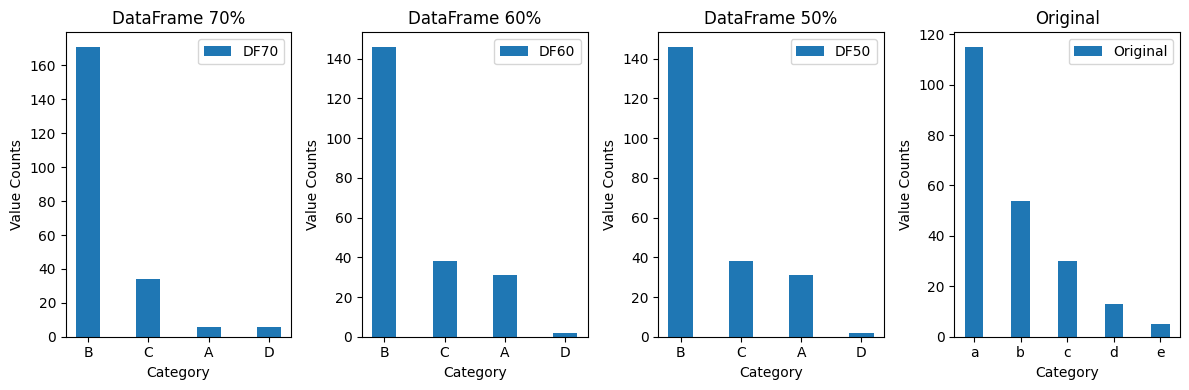

In [153]:
# Column names to plot from each DataFrame
col_df1 = 'category'  # Change this to your desired column from df1

# Create separate plots for each DataFrame
fig, axs = plt.subplots(1,4, figsize=(12, 4))

# Plotting DataFrame 1
value_counts_70 = data_70[col_df1].value_counts()
axs[0].bar(value_counts_70.index, value_counts_70.values, width=0.4, align='center', label='DF70')
axs[0].set_title('DataFrame 70%')

# Plotting DataFrame 2
value_counts_60 = data_60[col_df1].value_counts()
axs[1].bar(value_counts_60.index, value_counts_60.values, width=0.4, align='center', label='DF60')
axs[1].set_title('DataFrame 60%')

# Plotting DataFrame 3
value_counts_50 = data_50[col_df1].value_counts()
axs[2].bar(value_counts_50.index, value_counts_50.values, width=0.4, align='center', label='DF50')
axs[2].set_title('DataFrame 50%')

# Plotting DataFrame 4
value_counts_origianl = data_50['nutrition_grade_fr'].value_counts()
axs[3].bar(value_counts_origianl.index, value_counts_origianl.values, width=0.4, align='center', label='Original')
axs[3].set_title('Original')

# Adding labels, legend, and adjusting layout
for ax in axs:
    ax.set_xlabel('Category')
    ax.set_ylabel('Value Counts')
    ax.legend()

plt.tight_layout()
plt.show()

Confusion Matrix:
Predicted  A   B   C  D
Actual                 
a          8  78  29  0
b          5  42   5  2
c          7  20   3  0
d          6   6   1  0
e          5   0   0  0


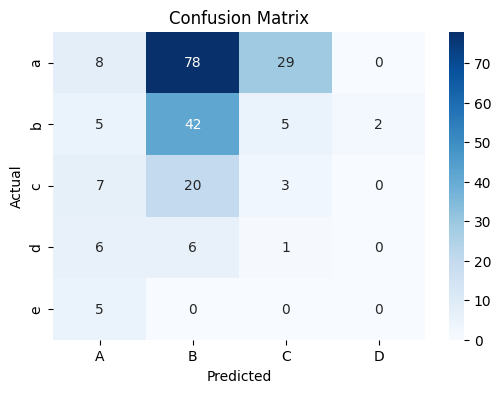

In [154]:
# Create a confusion matrix using crosstab
confusion_matrix = pd.crosstab(data_50['nutrition_grade_fr'], data_50['category'], rownames=['Actual'], colnames=['Predicted'])

print("Confusion Matrix:")
print(confusion_matrix)
# Plotting the confusion matrix as a heatmap using Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()